
## Linear regression

Today's second exercise will involve linear regression with stochastic gradient descent and with <a href="http://spark.apache.org/docs/latest/mllib-guide.html">MLlib</a>.

This exercise will be divided into three parts:

+ #### 1. Importing and preparing the data
+ #### 2. Creating a baseline benchmark
+ #### 3. Utilizing MLlib

<br>


In the following exercises you will need to replace the code parts in the cell that starts with following comment: "#Replace the `<INSERT>`"

To go through the notebook fill in the `<INSERT>`:s with appropriate code in the cells. 
To run a cell press Shift-Enter to run it and advance to the following cell or Ctrl-Enter to only run the code in the cell. You should do the exercises from the top to the bottom in this notebook, because following cells may depend on code in previous cells.

## Description of the data set
In this exercise we will utilize the <a href="http://archive.ics.uci.edu/ml/datasets/Parkinsons+Telemonitoring">Parkinsons Telemonitoring Data Set</a> used in the following article <a href="http://www.cabdyn.ox.ac.uk/complexity_PDFs/Network%20Journal%20Club%20PDFs/athanasios.pdf">Accurate telemonitoring of Parkinson’s disease progression by non-invasive speech tests</a>:

>Tracking Parkinson's disease (PD) symptom progression often uses the Unified Parkinson’s Disease Rating Scale (UPDRS), which requires the patient's presence in clinic, and time-consuming physical examinations by trained medical staff. Thus, symptom monitoring is costly and logistically inconvenient for patient and clinical staff alike, also hindering recruitment for future large-scale clinical trials. [...] We characterize speech with signal processing  algorithms, and statistically map these algorithms to UPDRS. We verify our findings on the largest database of PD speech in existence (~6,000 recordings from 42 PD patients, recruited to a six-month, multi-centre trial).

In essence, we will try to accurately predict a person's Parkinson's progression, meassured on 176 point scale (UPDRS) based on vocal features from the patients.

## 1. Importing and preparing the data
The data set is currently saved as a text file in the <a href="https://en.wikipedia.org/wiki/Comma-separated_values">comma separated values (CSV)</a> format, without a header, named "parkinsons_updrs.csv". We want to read in this textfile as separate lines into an rdd. A line is represented by the following column headers:

<b>
subject# <br>
age <br>
sex <br>
test_time  <br>
motor_UPDRS <br>
total_UPDRS <br>
Jitter(Abs) <br>
Jitter:RAP <br>
Shimmer:APQ3 <br>
Shimmer:DDA	<br>
Jitter(%) <br>
Jitter:PPQ5	<br>
Jitter:DDP <br>
Shimmer <br>
Shimmer(dB) <br>
Shimmer:APQ5 <br>
Shimmer:APQ11 <br>
NHR <br>
HNR <br>
RPDE <br>
DFA <br>
PPE</b>

Where total_UDPRS is the label of the observation (data point), which is a float between 0 and 176, motor_UPDRS is another test score, and the subject# is an integer that uniquely identifies each subject. The other 19 columns are numeric features.

If we want to run these lines as part of a script we should create a spark context:

In [1]:
#from pyspark import SparkContext, StorageLevel
#from pyspark.sql import SQLContext
#sc = SparkContext(master="local[*]")
#sqlContext = SQLContext(sc)

### 1.1 Read parkinsons_updrs.csv as an RDD

In [2]:
#Replace the <INSERT>
rawLines = sc.textFile("parkinsons_updrs.csv")


In [3]:
#sanity check
rawLines.first()

'1,72,0,5.6431,28.199,34.398,0.00662,3.38e-005,0.00401,0.00317,0.01204,0.02565,0.23,0.01438,0.01309,0.01662,0.04314,0.01429,21.64,0.41888,0.54842,0.16006'

### 1.2 Check if the RDD is correct

Utilize the <a href="https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.count">count method</a> to check how many observations there are in the RDD. Then use the <a href="https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.take">take method</a> to take the first observation:

In [4]:
#Replace the <INSERT>
numObs = rawLines.count()
print("The number of observations: {}".format(numObs))
sampleObs = rawLines.take(1)
sampleObs = sampleObs[0]
numFeatures = len(sampleObs.split(','))-3 # ignore 2 label columns and the column with the subject id
print("The number of features: {}".format(numFeatures))
print("One observation: {}".format(sampleObs))

The number of observations: 5875
The number of features: 19
One observation: 1,72,0,5.6431,28.199,34.398,0.00662,3.38e-005,0.00401,0.00317,0.01204,0.02565,0.23,0.01438,0.01309,0.01662,0.04314,0.01429,21.64,0.41888,0.54842,0.16006


In [5]:
#Helper functions to check results
import math
def check(x,y,label):
    if math.isclose(x,y):
        print("Yay, "+label+" is correct!")
    else:
        print("Nay, "+label+" is incorrect, please try again!")

def checkArray(x,y,label):
    if np.allclose(x,y):
        print("Yay, "+label+" is correct!")
    else:
        print("Nay, "+label+" is incorrect, please try again!")

In [6]:
#Check if the observations are correct
check(numObs, 5875, "the number of observations")
check(numFeatures, 19, "the number of features")
check(len(sampleObs), 152, "the first observation")

Yay, the number of observations is correct!
Yay, the number of features is correct!
Yay, the first observation is correct!


### 1.3 Using MLlib's LabeledPoint
In the MLlib library, an observation is represented by a <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint">LabeledPoint</a>, which consists of label, a double representing the value for regression purposes, or an integer value representing the class for classification purposes: 0 (negative) and 1 (positive) for binary classification and 0,1,2,... for multiclass. To accompany the label, there is also an feature vector, called features, which consists of numeric features stored as either a list, NumPy array, pyspark.mllib.linalg.SparseVector, or scipy.sparse column matrix. 

Implement the parseObs function below that takes a comma separated string and created a labeled point out of it using the following function: <a href="https://docs.python.org/2/library/string.html#string.split">string.split()</a>, create a parsed observation of sampleObs and print the label and features of it:

In [7]:
#Import some stuff
from pyspark.mllib.regression import LabeledPoint
import numpy as np

In [8]:
#Replace the <INSERT>
def parseObs(line):
    """Parses a comma separated string into a LabeledPoint.

    Args:
         line (string): A comma separated string where the 6th entry is the label,
         entries 1 and 5 are being ignored, and the other elements are the features.

    Returns:
         LabeledPoint: The line is parsed into a LabeledPoint, 
         which has a label and a list of features.
    """
#     featlst = []
#     for indx in range(len(obsplit)):
#         if indx not in [0, 4, 5]:
#             featlst.append(obsplit[indx])obsplit = line.split(",") # split observation
    obsplit = line.split(",") # split observation
    featlst = obsplit[1:4] + obsplit[6:]    # + will add nested lists as one lists and return the result. 
    return LabeledPoint(obsplit[5],featlst)

paresedObs = parseObs(sampleObs)
ObsLabel = paresedObs.label
ObsFeatures = paresedObs.features
print(ObsLabel, ObsFeatures)

34.398 [72.0,0.0,5.6431,0.00662,3.38e-05,0.00401,0.00317,0.01204,0.02565,0.23,0.01438,0.01309,0.01662,0.04314,0.01429,21.64,0.41888,0.54842,0.16006]


In [9]:
#Check if the LabeledPoint is correct
check(ObsLabel,34.398,"the label of the first observation")
check(len(ObsFeatures),19,"the features of the first observation")

Yay, the label of the first observation is correct!
Yay, the features of the first observation is correct!


### 1.4 Parsing the observations
Parse the points in rawLines into LabeledPoints using the above defined function parseObs, then create two RDD:s, one only containing the labels and one containing only features:

In [10]:
parsedObsInit = rawLines.map(lambda x: parseObs(x))
features = parsedObsInit.map(lambda x: x.features)
labels = parsedObsInit.map(lambda x: x.label)

In [11]:
#Check if the parsed labels and features are correct
check(features.collect()[5874][18],0.15336,"the features vector")
check(labels.collect()[5874],31.513,"the labels list")

Yay, the features vector is correct!
Yay, the labels list is correct!


### 1.5 Change the labels to start in origin

Let us first examine the range of labels (should be contained within the range $[0,176]$):

In [12]:
minScore = labels.reduce(min) # # will iteratively,going thru labels, give 2 entries to min which will return the min of the two
maxScore = labels.reduce(max)
print(minScore,maxScore)

7.0 54.992


In regression tasks, it is often usual to change labels such that they begin in origin. Convert parsedObsInit to a new RDD consisting of LabeledPoint:s with the labels changed such as that smallest label equals zero:

In [13]:
parsedData = parsedObsInit.map(lambda x: LabeledPoint(x.label - minScore, x.features))
labels = parsedData.map(lambda x: x.label)
minScoreNew = labels.reduce(min)
maxScoreNew = labels.reduce(max)
print(minScoreNew, maxScoreNew)

0.0 47.992


In [14]:
#Check if the change in labels is correct
check(labels.take(1)[0],27.398000000000003,"the change in labels")

Yay, the change in labels is correct!


### 1.6 Summary statistics of the features
Before starting a ML task, you should take a look at the features, and a statistical summary can be a good start: 
<a href="http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.stat.Statistics.colStats">colStats()</a> returns an instance of <a href="http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.stat.MultivariateStatisticalSummary">MultivariateStatisticalSummary</a>
, which contains the column-wise max, min, mean, variance, and number of nonzeros, as well as the total count.

The data set we are currently working on, is a well-behaved data set, we got no missing values and no extreme minimum or maximum values.


In [15]:
from pyspark.mllib.stat import Statistics
summary = Statistics.colStats(features)
print("The number of non zero features:\n"+str(summary.numNonzeros()))
print("The min of the features:\n"+str(summary.min()))
print("The max of the features:\n"+str(summary.max()))
print("The mean of the features:\n"+str(summary.mean()))
print("The variance of the features:\n"+str(summary.variance()))

The number of non zero features:
[5875. 1867. 5875. 5875. 5875. 5875. 5875. 5875. 5875. 5875. 5875. 5875.
 5875. 5875. 5875. 5875. 5875. 5875. 5875.]
The min of the features:
[ 3.6000e+01  0.0000e+00 -4.2625e+00  8.3000e-04  2.2500e-06  3.3000e-04
  4.3000e-04  9.8000e-04  3.0600e-03  2.6000e-02  1.6100e-03  1.9400e-03
  2.4900e-03  4.8400e-03  2.8600e-04  1.6590e+00  1.5102e-01  5.1404e-01
  2.1983e-02]
The max of the features:
[8.5000e+01 1.0000e+00 2.1549e+02 9.9990e-02 4.4559e-04 5.7540e-02
 6.9560e-02 1.7263e-01 2.6863e-01 2.1070e+00 1.6267e-01 1.6702e-01
 2.7546e-01 4.8802e-01 7.4826e-01 3.7875e+01 9.6608e-01 8.6560e-01
 7.3173e-01]
The mean of the features:
[6.48049362e+01 3.17787234e-01 9.28637220e+01 6.15376170e-03
 4.40271183e-05 2.98718468e-03 3.27685106e-03 8.96167660e-03
 3.40352170e-02 3.10960000e-01 1.71557038e-02 2.01441838e-02
 2.74808613e-02 5.14669413e-02 3.21198175e-02 2.16794951e+01
 5.41472933e-01 6.53239656e-01 2.19589179e-01]
The variance of the features:
[7.781

### 1.7 Scaling and normalizing the observations
In the MLlibrary there exist two classes representing <a href="https://en.wikipedia.org/wiki/Feature_scaling">feature scaling</a> which are the
<a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.feature.StandardScalerModel">StandardScaler</a> and the <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.feature.Normalizer">Normalizer</a>. The StandardScaler can take an input of RDD[Vector], learn the summary statistics, and then return a model which can transform the input dataset into unit standard deviation and/or zero mean features, i.e. taking the $x'$ of each feature. The Normalizer scales individual feature vectors to have unit p-norm. i.e. calculating $\mathbf{v'}$.

$$
x' = \frac{x-\hat{x}}{\sigma}
\qquad
\|\mathbf{v}\|_p = (\sum\limits_{i=1}^n |x_i|^p)^{1/p}
\qquad
\mathbf{v'} = \frac{\mathbf{v}}{\|\mathbf{v}\|_p}
$$
The following page contains examples of feature scaling and normalizing <a href="http://spark.apache.org/docs/latest/mllib-feature-extraction.html#model-fitting">examples</a>. Scale the features with the standard deviation, but not the mean and then normalize the scaled features with the $p=\infty$ norm:

In [16]:
#Import some more stuff
from pyspark.mllib.feature import StandardScaler
from pyspark.mllib.feature import Normalizer

In [17]:
#Replace the <INSERT>
# Check in the slides the methods to use
scaler = StandardScaler() #initialize the StandardScaler object
scalerModel = scaler.fit(features) #run the fit method to get a fitted model
scaledFeatures = scalerModel.transform(features) # transform features using the fitted model
norm = Normalizer(p=float("inf")) # initialize the Normalizer model with p norm infinity
normScaledFeatures = norm.transform(scaledFeatures) # normalize the scaled features with p infinity norm
normScaledObs = labels.zip(normScaledFeatures) # combine with the labels to get observation
normScaledObs = normScaledObs.map(lambda x: LabeledPoint(x[0], x[1])) # get a regression LabeledPoint for each observation
print(normScaledObs.take(1)) #sanity check

[LabeledPoint(27.398000000000003, [1.0,0.0,0.012936502688516597,0.1442135808546187,0.11508695875970482,0.15727859613046682,0.10408369188902618,0.1574087724821457,0.12164306674385247,0.12238618540661764,0.13309954400102444,0.09624390810306006,0.10188566564132602,0.13309941098677056,0.029330872745971088,0.61787426879459,0.5082068087670532,0.9476892091309828,0.21432852613822134])]


In [18]:
check(scaledFeatures.take(1)[0][18],1.7493184105,"the scaled features")
check(normScaledFeatures.take(1)[0][18],0.214328526138,"the normalized and scaled features")

Yay, the scaled features is correct!
Yay, the normalized and scaled features is correct!


### 1.8 Illustrating the features
To try to find patterns in the features, we will visualize the data set, by projecting it from 19 dimensions to 2. This dimensionality reduction is achieved by using <a href="https://en.wikipedia.org/wiki/Principal_component_analysis">PCA</a>, a type of unsupervised learning, which we will explain further next week.

In [19]:
from sklearn.decomposition import TruncatedSVD
#Calculate the PCA of normScaledFeatures
Y = TruncatedSVD(n_components=2).fit_transform(normScaledFeatures.collect())

In [20]:
#To inline the plots
%matplotlib inline

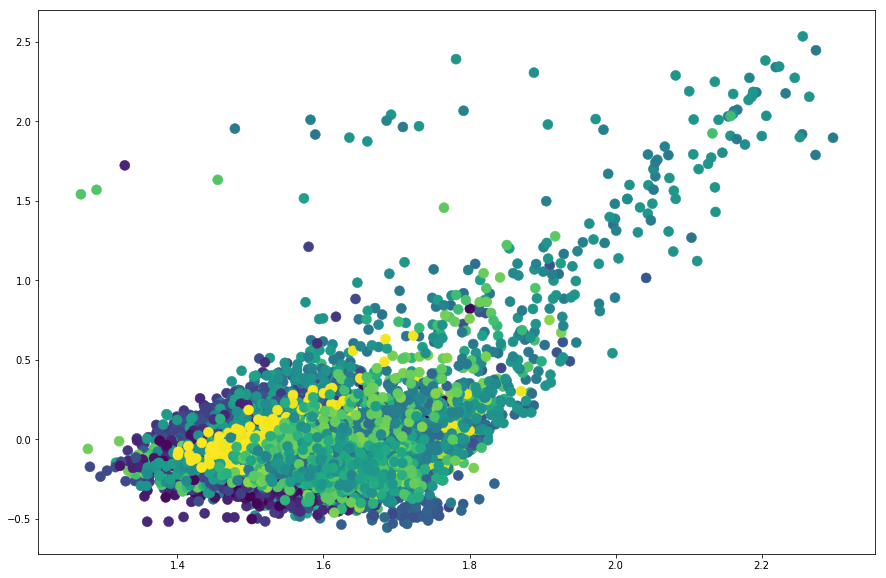

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.scatter(Y[:, 0], Y[:, 1], c=labels.collect(),linewidths=.5, s=100)
# plt.xlabel("first component")
# plt.ylabel("second component")

If you look at the graph above, you probably see some regions that look like clusters, and others where the colors are intermingled. The color map associates lower values to blue, and higher values to red; values in middle are in green. The intermingled points makes this a hard problem, to try to find a linear regression that correctly predicts the labels will not be an easy task. 

### 1.9  Splitting the data into training, validation, and test sets 
Our last task with preparing the data set is to split it into a training, validation and test set. An usual split is 70%/15%/15%.

Utilize the <a href="https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit">randomSplit</a> function, with the weigths and seed specified below. Then cache the three data sets, because you will reuse them during this exercise:

In [22]:
#Replace the <INSERT>
weights = [.7, .15, .15] # specify percentages for data spliting
seed = 0 #for reproducibility
trainObs, valObs, testObs = normScaledObs.randomSplit(weights,seed)

#persist the observations in MEMORY_ONLY storage level
trainObs.cache()
valObs.cache()
testObs.cache()

PythonRDD[35] at RDD at PythonRDD.scala:52

In [23]:
numTrain = trainObs.count()
numVal = valObs.count()
numTest = testObs.count()

print("Size of train set: {}".format(numTrain))
print("Size of validation set: {}".format(numVal))
print("Size of test set: {}".format(numTest))
print("Size of total data set: {}".format(numTrain+numVal+numTest))

Size of train set: 4107
Size of validation set: 886
Size of test set: 882
Size of total data set: 5875


In [24]:
#Check if the data sets are correct
check(numTrain, 4107, "the train set")
check(numVal, 886, "the validation set")
check(numTest, 882, "the test set")
check(numTrain+numVal+numTest, 5875, "the total data set")

Yay, the train set is correct!
Yay, the validation set is correct!
Yay, the test set is correct!
Yay, the total data set is correct!


## 2. Creating a baseline benchmark
### 2.1 The average UPDRS score
An quite natural baseline to compare your result against is to predict the same value for each observation, using the average value.

Compute the average UPDRS score (the label) below:

In [25]:
#calculate the mean of the label for training dataset
meanUPDRS = trainObs.map(lambda x: x.label).mean() 
print(meanUPDRS)

22.0677837837838


In [26]:
#Check if the average UPDRS is correct
check(round(meanUPDRS),22.0, "the average UPDRS")

Yay, the average UPDRS is correct!


### 2.2 The mean absolute error
For evaluation purposes, we will use the <a href="https://en.wikipedia.org/wiki/Mean_absolute_error"> mean absolute error</a> (MAE) as a metric. The MAE is defined as the sum of the absolute value off the label ($y_i$) minus the predicted value ($\hat{y}_i$), divided by the number of labels:
$$
\frac{1}{n}\sum\limits_{i=1}^n |y_i-\hat{y}_i|
$$

Implement the function below that calculates the mean absolute error for a RDD of (label, prediction) tuples. You will use map() and the mean() methods.

In [27]:
#Replace the <INSERT>
def calcMAE(labelPred):
    """Computes the mean absolute error for a RDD of (label, prediction) tuples.

    Args:
        labelPred (RDD of (float, float)): A RDD consisting of (label, prediction) tuples.

    Returns:
        float: The mean absolute error.
    """
    meanSumDiff = (labelPred.map(lambda x: abs(x[1]-x[0]))).mean()
    return meanSumDiff


labelPred = sc.parallelize([(4., 1.), (2., 1.), (17., 17.)])
# RMSE = sqrt[|4-1| + |2-1| + |17-17|) / 3] = 1.33333333333
testMAE = calcMAE(labelPred)
print(testMAE)

1.3333333333333333


In [28]:
check(round(testMAE,2),1.33, "the calculate MAE")

Yay, the calculate MAE is correct!


### 2.3 The MAE of the train, validation, and test set
We will now calculate the baseline benchmark MAE value for all three data sets.

In the code below please compute the train, validation, and test benchmark MAE, by first creating a pair RDD consisting of (label, averageUPDRS) and then using the above defined function to calculate the MAE:

In [29]:
trainLabelPred = trainObs.map(lambda x: (x.label, meanUPDRS))
trainBenchMAE = calcMAE(trainLabelPred)

trainLabelPred = valObs.map(lambda x: (x.label, meanUPDRS))
valBenchMAE = calcMAE(trainLabelPred)

testLabelPred = testObs.map(lambda x: (x.label, meanUPDRS))
testBenchMAE = calcMAE(testLabelPred)

print('Train benchmark MAE = {0:.3f}'.format(trainBenchMAE))
print('Validation benchmark MAE = {0:.3f}'.format(valBenchMAE))
print('Test benchmark MAE = {0:.3f}'.format(testBenchMAE))

Train benchmark MAE = 8.617
Validation benchmark MAE = 8.714
Test benchmark MAE = 8.809


In [30]:
check(round(trainBenchMAE,3),8.617, "the train benchmark MAE")
check(round(valBenchMAE,3),8.714, "the validation benchmark MAE")
check(round(testBenchMAE,3),8.809, "the test benchmark MAE")

Yay, the train benchmark MAE is correct!
Yay, the validation benchmark MAE is correct!
Yay, the test benchmark MAE is correct!


The result of linear regression with gradient descent is about 0.305 better than the benchmark. It is an improvement compared to the benchmark, but not a huge difference. This means that this is a hard task to get good result with linear regression.

In [31]:
8.809-8.46

0.3489999999999984

## 3. Utilizing MLlib

### 3.1 Linear regression with stochastic gradient descent
The MLlib's <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionWithSGD">LinearRegressionWithSGD</a> uses a stochastic gradient approximation, allowing for L1 or L2 regularization, and including an intercept in the model.

Implement the code below, use the LinearRegressionWithSGD to train a model with the iterations, step size, reguralization parameter set to the below values, use the default values for the rest. This method returns a <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel">LinearRegressionModel</a>, which you can use to predict LabeledPoint:s:

In [32]:
#Even more stuff imported!
from pyspark.mllib.regression import LinearRegressionWithSGD

In [33]:
#Replace the <INSERT>
iters = 20  # iterations
alpha = 1.0  # step
reg = 1e-4  # regParam
linRegSGD = LinearRegressionWithSGD.train(trainObs, iterations=iters, step=alpha, regParam=reg)

#Get the weigths of the model
weightsLRSGD = linRegSGD.weights
print (weightsLRSGD)


[8.347639602207122,-0.26630605844837757,2.097928992420213,1.0293196979169754,1.186259747981341,0.8610939237461529,0.7206056159832323,0.8612225300297591,1.1542106749149301,1.2249328067127219,1.0801512025424045,1.0212841612459742,1.483596930899449,1.0801433195847303,0.2409986828329387,3.517284630534948,5.400418516339896,7.786272686579367,2.9177659440107995]


In [34]:
checkArray(weightsLRSGD, [8.34763960221,-0.266306058448,2.09792899242,1.02931969792,
                          1.18625974798,0.861093923746,0.720605615983,0.86122253003,
                          1.15421067491,1.22493280671,1.08015120254,1.02128416125,
                          1.4835969309,1.08014331958,0.240998682833,3.51728463053,
                          5.40041851634,7.78627268658,2.91776594401]
          ,"the weights of the model")

Yay, the weights of the model is correct!


### 3.2 Evaluate the Linear regression with SGD
We will check the new model on the validation set:

In [35]:
labelPred = valObs.map(lambda lp: (lp.label, linRegSGD.predict(lp.features)))
valLRSGDMAE = calcMAE(labelPred)

print("Validation MAE:\n\tBenchmark: = {0:.3f}\n\tLRSGD = {1:.3f}"
      .format(valBenchMAE, valLRSGDMAE))
print("\nThe difference between Benchmark and SGD = {0:.3f}".format(valBenchMAE-valLRSGDMAE))

Validation MAE:
	Benchmark: = 8.714
	LRSGD = 8.517

The difference between Benchmark and SGD = 0.196


### 3.3 Improve the hyperparameters
All the options to LinearRegressionWithSGD can be seen as hyperparameters: iterations, step size, mini batch fraction, regularization type, reguralization parameter, and intercept. For this task the most important parameters to tune is the iterations, and step size options. So we will do it in the following cells, often if you have reasonable values for the other parameters, you can tune one parameter in isolation.

So run the following cells to find optimal values for the two parameters:

#### 4.3.1 Improve the iterations parameter
We will try several values for the iteration parameter and pick the one that gets the best result:

In [36]:
bestMAE = valLRSGDMAE
bestIters = 0
for iters in [10,50,100,500,1000]:
    model = LinearRegressionWithSGD.train(trainObs, iterations=iters, step=alpha, regParam=reg)
    labelPred = valObs.map(lambda lp: (lp.label, model.predict(lp.features)))
    valMAE = calcMAE(labelPred)
        
    if valMAE < bestMAE:
        bestMAE = valMAE
        bestIters = iters
        
    print("iters = {0}, MAE = {1:.3f}".format(iters, valMAE))
        
print("Best MAE for the following value of iters = {0}, MAE = {1:.3f}".
      format(bestIters, bestMAE))

iters = 10, MAE = 8.534
iters = 50, MAE = 8.486
iters = 100, MAE = 8.452
iters = 500, MAE = 8.405
iters = 1000, MAE = 8.405
Best MAE for the following value of iters = 500, MAE = 8.405


#### 3.3.2 Improve the step size parameter (alpha)
We will try some values for the step size parameter (this may take while on a slow computer):

In [37]:
bestMAE = valLRSGDMAE
bestAlpha = 0
for alpha in np.arange(1,6,1):
    model = LinearRegressionWithSGD.train(trainObs, iterations=bestIters, step=alpha,regParam=reg)
    labelPred = valObs.map(lambda lp: (lp.label, model.predict(lp.features)))
    valMAE = calcMAE(labelPred)
        
    if valMAE < bestMAE:
        bestMAE = valMAE
        bestAlpha = alpha
        
    print("alpha = {0}, MAE = {1:.3f}".format(alpha, valMAE))
        
print("Best MAE for the following value of alpha = {0}, MAE = {1:.3f}".
      format(bestAlpha, bestMAE))

alpha = 1, MAE = 8.405
alpha = 2, MAE = 8.298
alpha = 3, MAE = 8.251
alpha = 4, MAE = 8.227
alpha = 5, MAE = 8.215
Best MAE for the following value of alpha = 5, MAE = 8.215


### 3.4 Evaluate the linear regression with SGD and improved hyperparameters
Let use evaluate the new model with the optimal parameters:

In [38]:
print(("Validation MAE:\n\tBenchmark: = {0:.3f}\n\tLRSGD = {1:.3f}"+
      "\n\tLRSGDOpt = {2:.3f}").format(valBenchMAE, valLRSGDMAE, bestMAE))
print("\nThe difference between Benchmark and SGDOpt = {0:.3f}".format(valBenchMAE-bestMAE))

Validation MAE:
	Benchmark: = 8.714
	LRSGD = 8.517
	LRSGDOpt = 8.215

The difference between Benchmark and SGDOpt = 0.499


The difference between the benchmark and the model with optimal parameters is 0.626, almost the double of the value that we got in part 3.4 of this exercise. A good relative increase, although not that great in absolute terms, but again this is hard task to do linear regression on.

### 3.5 Evaluate all the models on the test set
And finally we will evaluate all the models on the test set:

In [39]:
#Calculate the test MAE for linear regressions with SGD
labelPred = testObs.map(lambda lp: (lp.label, linRegSGD.predict(lp.features)))
testLRSGDMAE = calcMAE(labelPred)

#Calculate the test MAE for linear regressions with SGD, with (optimal) hyperparameters
model = LinearRegressionWithSGD.train(trainObs, iterations=bestIters, step=bestAlpha,
                                          regParam=reg, intercept=False)
labelPred = testObs.map(lambda lp: (lp.label, model.predict(lp.features)))
testOptMAE = calcMAE(labelPred)

print(("Test MAE:\n\tBenchmark: = {0:.3f}\n\tLRSGD = {1:.3f}"+
      "\n\tLRSGDOpt = {2:.3f}").format(testBenchMAE, testLRSGDMAE, 
                                       testOptMAE))
print("\nThe difference between Benchmark and SGDOpt = {0:.3f}".format(testBenchMAE-testOptMAE))

Test MAE:
	Benchmark: = 8.809
	LRSGD = 8.532
	LRSGDOpt = 8.271

The difference between Benchmark and SGDOpt = 0.539


### 4.5 Post mortem discussion
To have something to compare with, we can look at the original article <a href="http://www.cabdyn.ox.ac.uk/complexity_PDFs/Network%20Journal%20Club%20PDFs/athanasios.pdf">Accurate telemonitoring of Parkinson’s disease progression by non-invasive speech tests</a> at the last page we can find the best result for two types of regression, one linear: <a href="https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares">Iteratively reweighted least squares</a> and one non-linear: <a href="https://en.wikipedia.org/wiki/Decision_tree_learning#Types">classification and regression tree</a>.

The linear ones best result is a MAE of 8.46, but this result is on a mean of 1000 runs of 10-fold cross validation, so it is not directly comparable, but can give an indication of the quality of the result. The non-linear method has a result of 7.52, i.e. almost one point lower, which indicates that this task is non-linear in it's nature.

As an optional home assignment you will implement the gradient descent yourself.